In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from environment_batched import BatchedMarket, BatchedLeontief, BatchedFirm, BatchedEnvironment
from models.policy import BetaPolicyNetwork, DeterministicPolicyNetwork, BetaPolicyNetwork2
from models.critic import CentralizedCritic, CentralizedCritic2
from models.utils import get_state, get_state_dim, process_actions, get_action_dim
from trainer import TrainerAC, TrainerSAC, Trainer3
from utils.plotting import plot_actions, plot_environment

In [13]:
torch.manual_seed(123)
torch.backends.cudnn.deterministic = True
device = 'cuda'
# Гиперпараметры рынка
market_kwargs = dict(
    start_volumes=2,      # У всех фирм в резервах изначально 4 товара А и 10 товара Б
    base_price=50,         # Изначальные цены на рынке - 50 
    start_gains=500,       # Изначальные финансовые ресурсы у каждой фирмы - 500
    deprecation_steps=2,   # За сколько ходов износится основной капитал
    min_price=1,           # Минимальная возможная цена на рынке
    max_price=100          # Максимальная возможная цена на рынке
)

In [17]:
# Производственные функции
prod_functions = [
    BatchedLeontief(torch.tensor([1, 0]), torch.tensor([0, 2]), device=device),  # 1 товара А + 0 товара Б => 2 товара Б 
    BatchedLeontief(torch.tensor([0, 1]), torch.tensor([2, 0]), device=device),  # 0 товара А + 1 товар  Б => 2 товара А.
    BatchedLeontief(torch.tensor([0, 1]), torch.tensor([2, 0]), device=device),  # 0 товара А + 1 товар  Б => 2 товара А.

]
# # Инвестиционные функции
# invest_functions = [
#     BatchedLeontief(torch.tensor([1, 1]), torch.tensor(1), device=device),  # 1 товар А + 1 товар Б => 1 лимит
#     BatchedLeontief(torch.tensor([1, 1]), torch.tensor(1), device=device),  # 1 товар А + 1 товар Б => 1 лимит
# ]

# Фирмы ориентируются чисто на финансовые ресурсы. Порядок ходов не перемешивается.

In [18]:
env = BatchedEnvironment(market_kwargs,
                         BetaPolicyNetwork2, 
                         prod_functions,
                         invest_functions=None,
                         target='finance',  # Вот это меняется
                         batch_size=1024)
trainer = TrainerSAC(env,
                     q_critic=CentralizedCritic2,
                     batch_size=512, 
                     buffer_size=524288,
                     learning_rates=(1e-3, 1e-3))

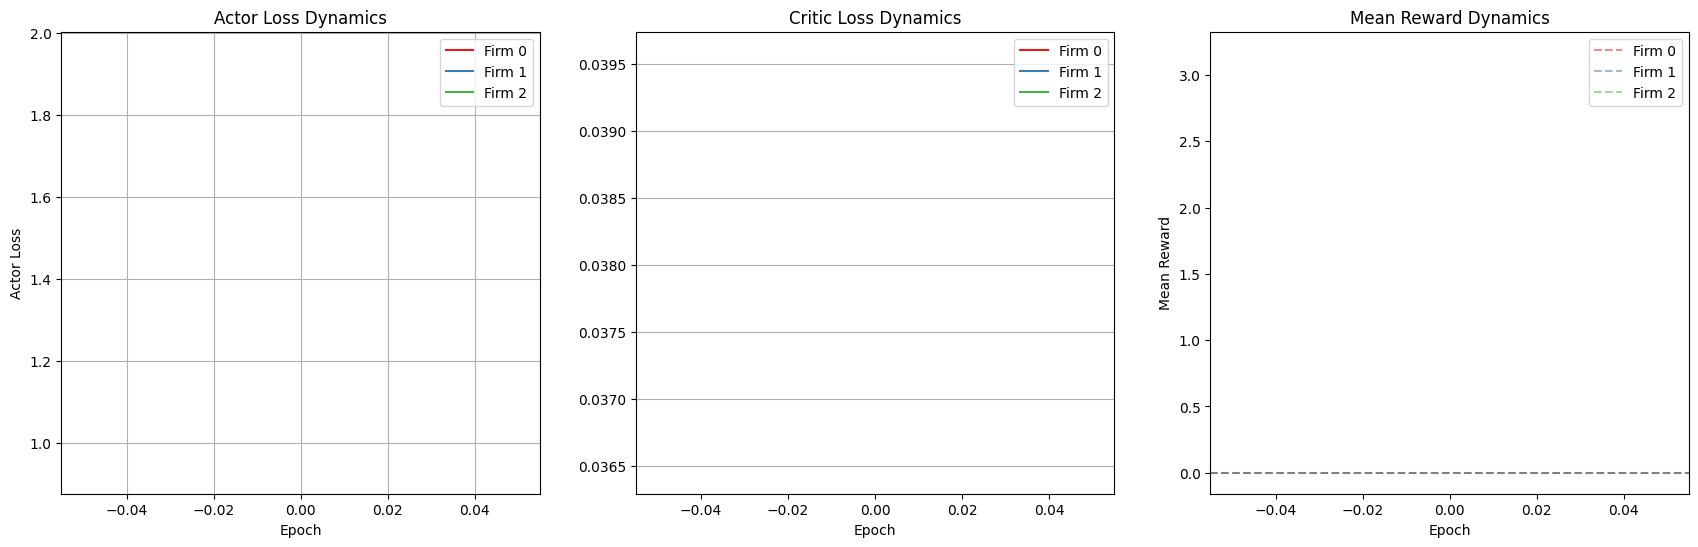

  1%|          | 2/200 [00:03<05:17,  1.60s/it, LR=0.00099, Buffer Index=65536, Order=[0, 1, 2]] 


KeyboardInterrupt: 

In [19]:
# env.reset()
trainer.train(n_epochs=200,         # Количество эпох 
              episode_length=32,    # Сколько шагов походит каждая фирма до того, как среда перезапустится
              shuffle_order=False)  # Перемешивать ли порядок ходов от эпохи к эпохе

In [20]:
env.reset()
env.change_batch_size(1)  

In [21]:
n_periods = 64 * env.market.n_firms
for i in range(n_periods):
    env.step_and_record(i % env.market.n_firms)

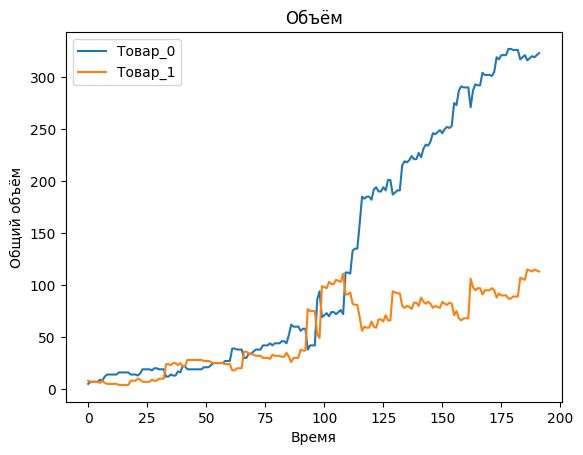

In [36]:
import numpy as np 
import matplotlib.pyplot as plt
env_history = env.state_history

volumes = np.stack([x['volume_matrix'] for x in env_history]).T
reserves = np.stack([x['reserves'] for x in env_history]).T
total = (volumes + reserves).sum(axis=1).T
plt.plot(total)
plt.xlabel('Время')
plt.ylabel('Общий объём')
plt.title('Объём')
plt.legend([f'Товар_{i}' for i in range(total.shape[1])])
plt.show()

In [28]:
total = (volumes + reserves).sum(axis=1)

array([[  5,   7,   7,   7,   7,   9,   8,  12,  14,  14,  14,  14,  14,
         16,  16,  16,  16,  16,  14,  14,  14,  13,  15,  19,  19,  19,
         19,  18,  20,  20,  19,  19,  19,  12,  12,  14,  13,  13,  17,
         16,  22,  22,  19,  19,  19,  19,  19,  19,  19,  21,  21,  21,
         23,  25,  25,  25,  25,  25,  27,  27,  27,  39,  39,  38,  38,
         38,  30,  30,  34,  34,  36,  38,  38,  38,  42,  42,  42,  44,
         42,  44,  44,  44,  46,  46,  44,  52,  62,  60,  60,  60,  56,
         58,  58,  38,  42,  42,  42,  86,  94,  69,  71,  73,  70,  74,
         74,  72,  74,  76,  72, 112, 112, 111, 133, 135, 135, 159, 185,
        183, 185, 185, 182, 192, 194, 190, 190, 194, 191, 201, 201, 187,
        189, 191, 191, 215, 219, 218, 220, 224, 221, 221, 227, 223, 231,
        235, 234, 238, 246, 245, 247, 249, 246, 250, 252, 251, 253, 275,
        273, 287, 291, 290, 290, 290, 271, 287, 293, 292, 292, 304, 302,
        302, 302, 301, 305, 319, 317, 321, 321, 321

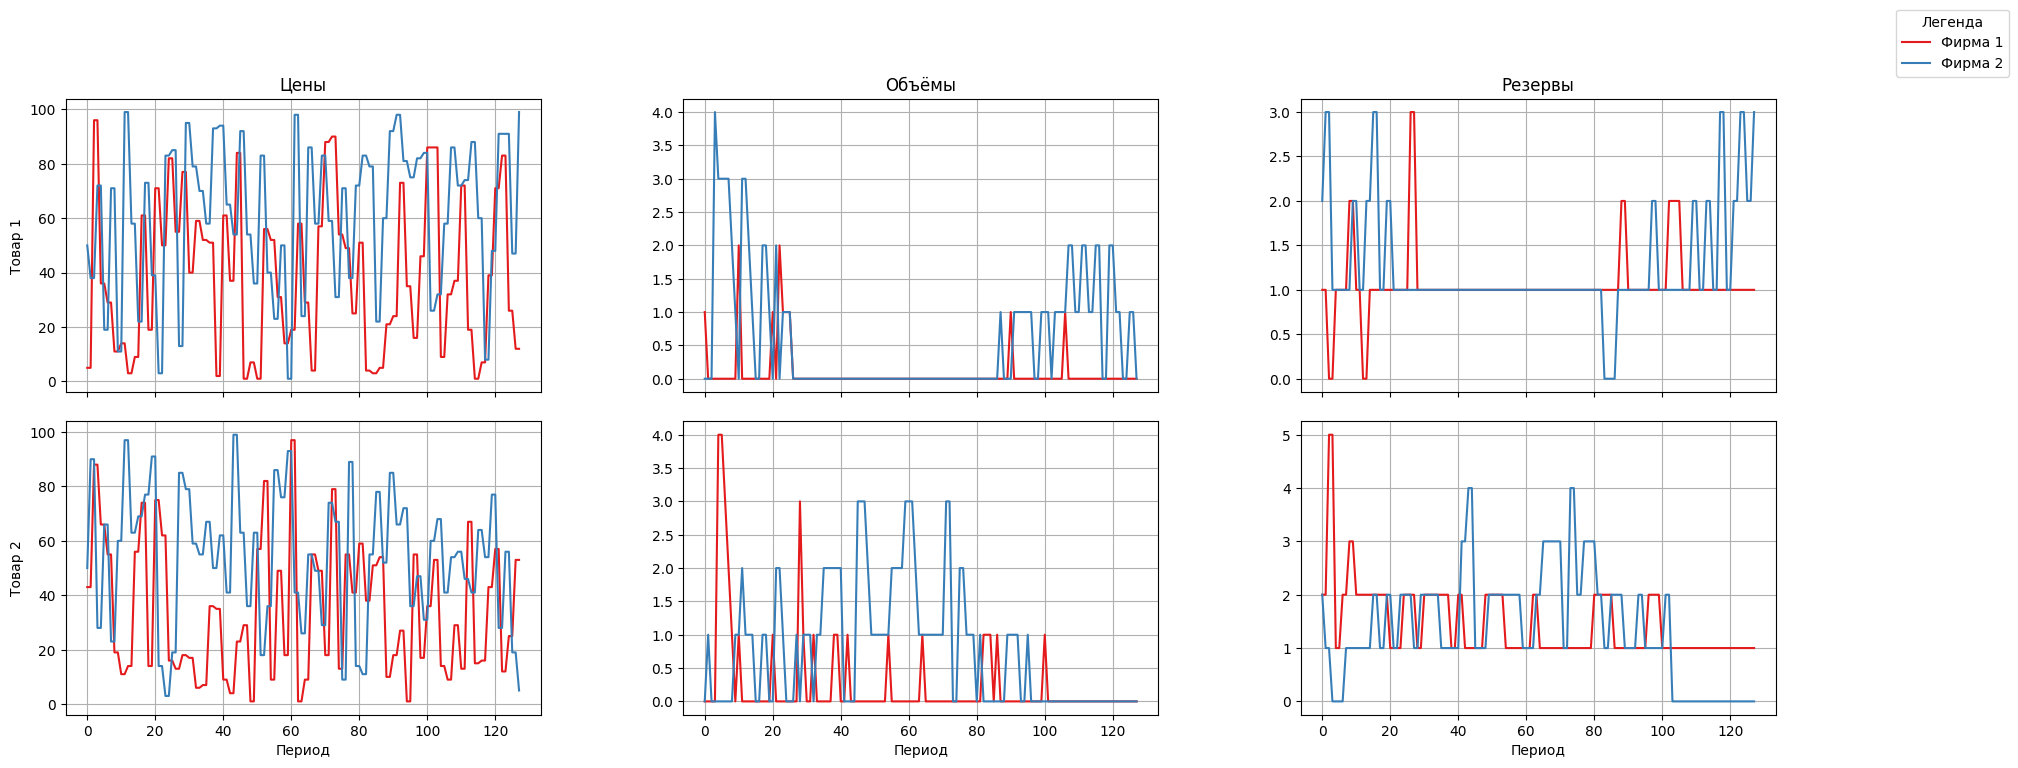

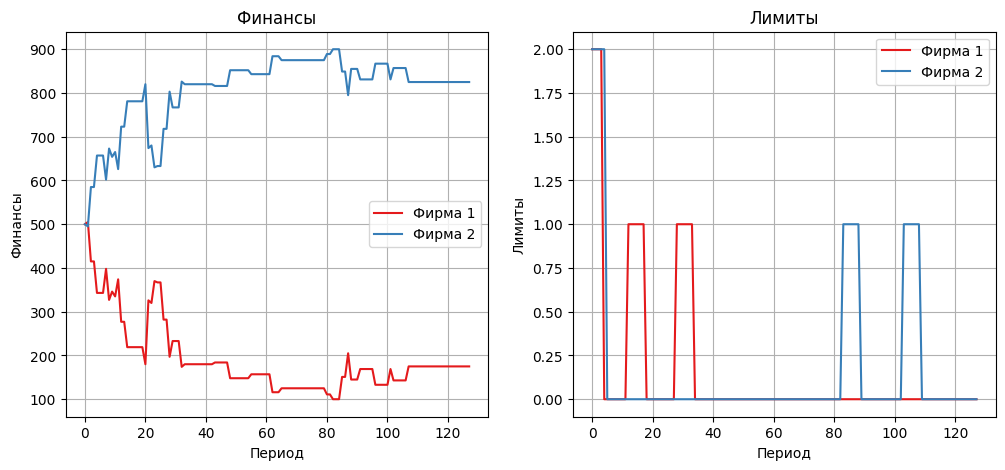

In [9]:
plot_environment(env.state_history)

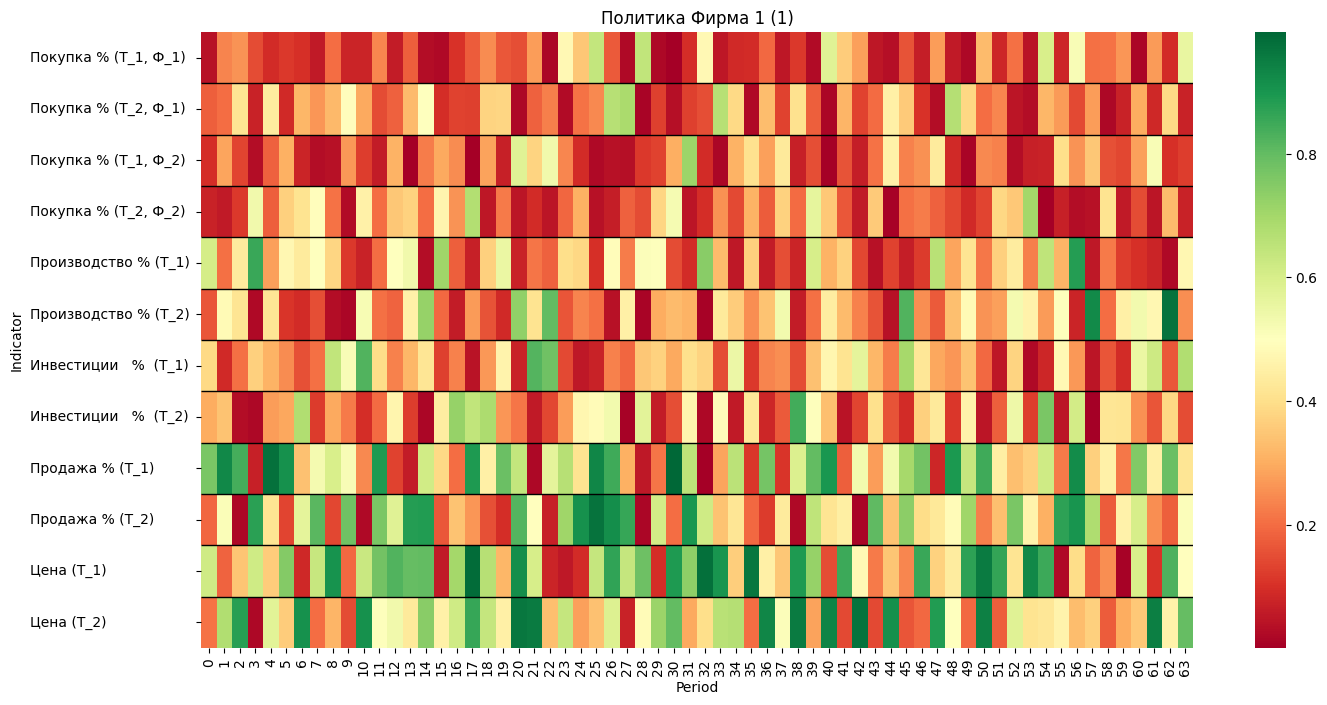

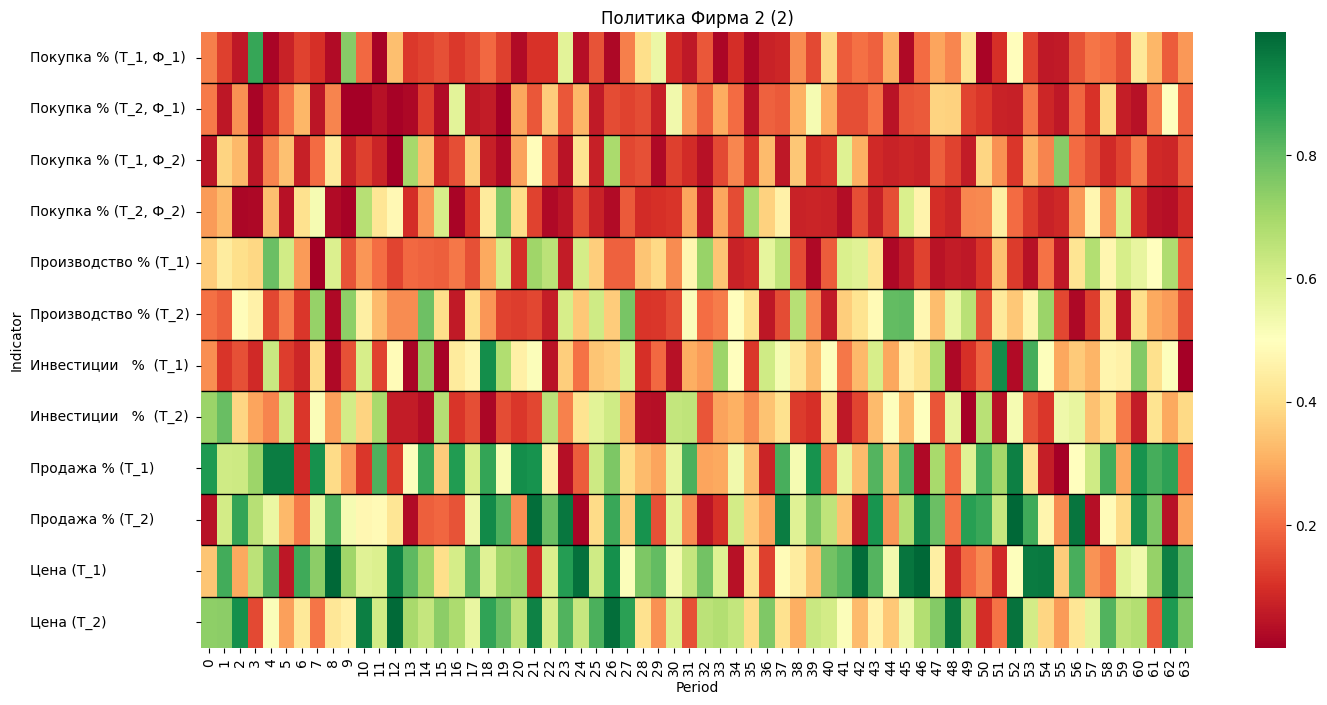

In [10]:
plot_actions(env.actions_history[0], 'Политика Фирма 1 (1)')
plot_actions(env.actions_history[1], 'Политика Фирма 2 (2)')

# Фирмы ориентируются чисто на финансы, порядок ходов перемешивается.

In [13]:
# Производственные функции
prod_functions = [
    BatchedLeontief(torch.tensor([1, 0]), torch.tensor([0, 2]), device=device),  # 1 товара А + 0 товара Б => 2 товара Б 
    BatchedLeontief(torch.tensor([0, 1]), torch.tensor([2, 0]), device=device),  # 0 товара А + 1 товар  Б => 2 товара А.
]
# Инвестиционные функции
invest_functions = [
    BatchedLeontief(torch.tensor([1, 1]), torch.tensor(1), device=device),  # 1 товар А + 1 товар Б => 1 лимит
    BatchedLeontief(torch.tensor([1, 1]), torch.tensor(1), device=device),  # 1 товар А + 1 товар Б => 1 лимит
]

In [33]:
env = BatchedEnvironment(market_kwargs,
                         BetaPolicyNetwork2, 
                         prod_functions,
                         invest_functions=invest_functions,
                         target='finance',  # Вот это меняется
                         batch_size=1024)
trainer = TrainerSAC(env,
                     q_critic=CentralizedCritic2,
                     batch_size=512, 
                     buffer_size=524288,
                     learning_rates=(1e-3, 1e-3), entropy_reg=1e-4)

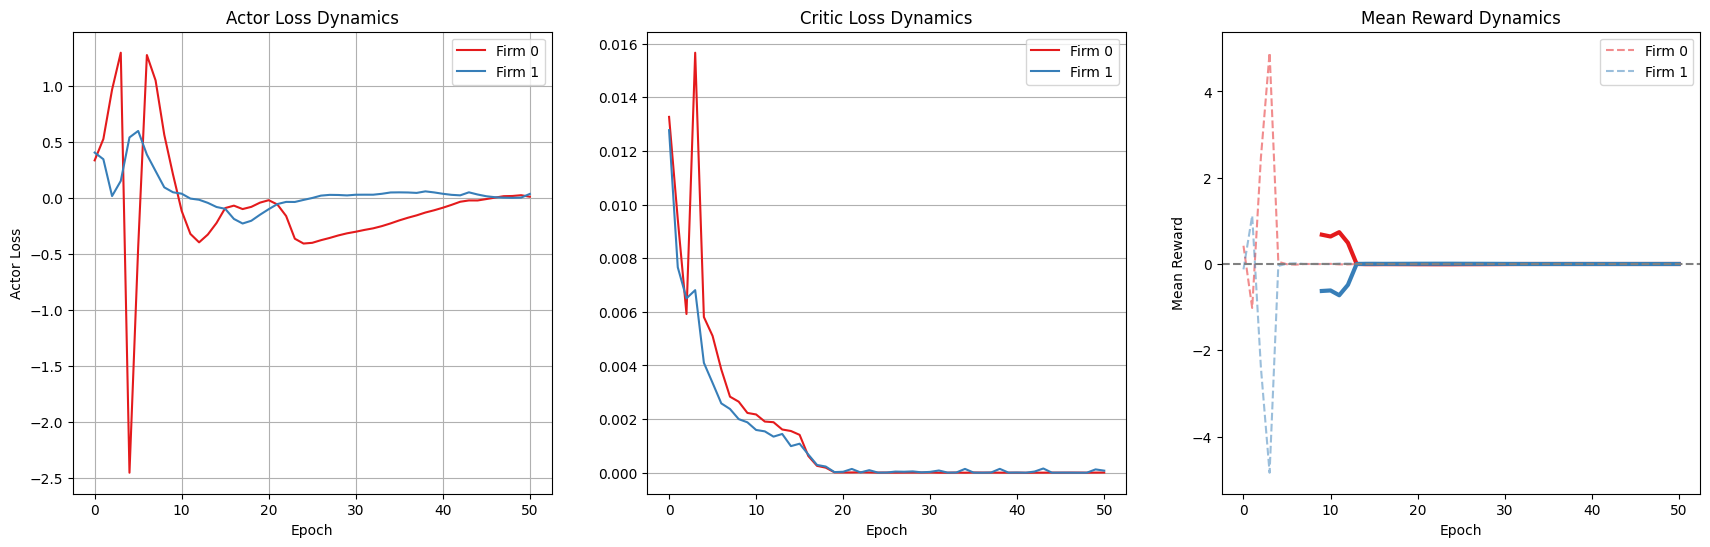

 16%|██████                                | 32/200 [00:27<02:15,  1.24it/s, LR=0.000759, Buffer Index=263168, Order=[1, 0]]

In [ ]:
trainer.train(n_epochs=200,
              episode_length=32,
              shuffle_order=True)

In [35]:
env.reset()
env.change_batch_size(1)  

In [36]:
n_periods = 32 * env.market.n_firms
for i in range(n_periods):
    env.step_and_record(i % env.market.n_firms)

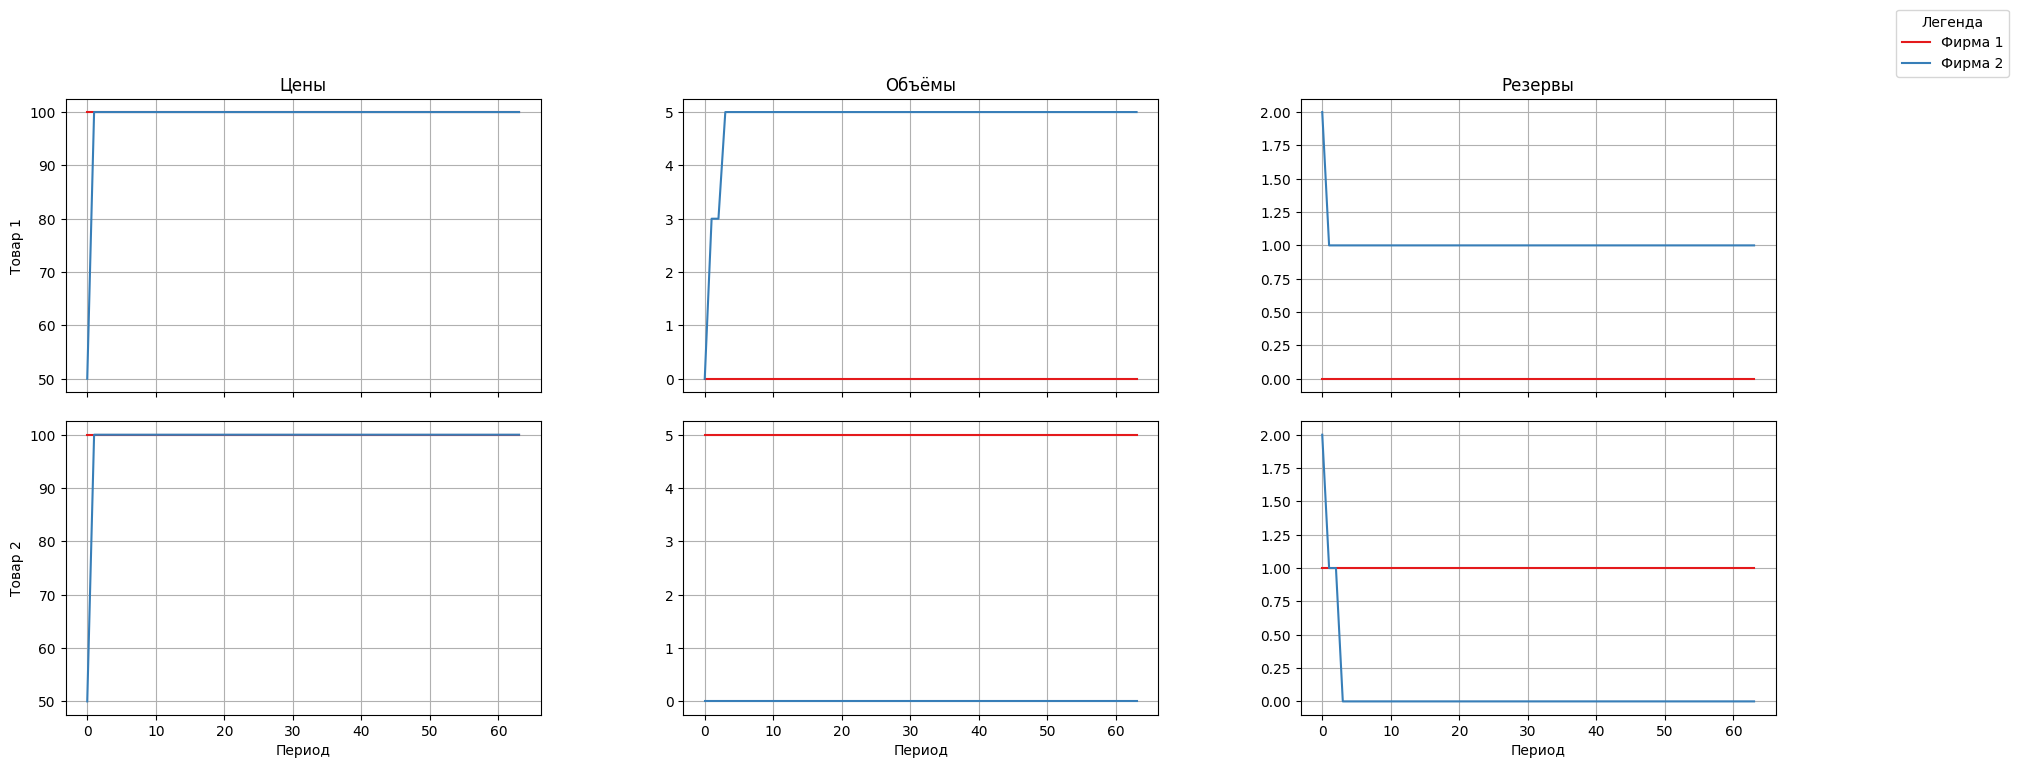

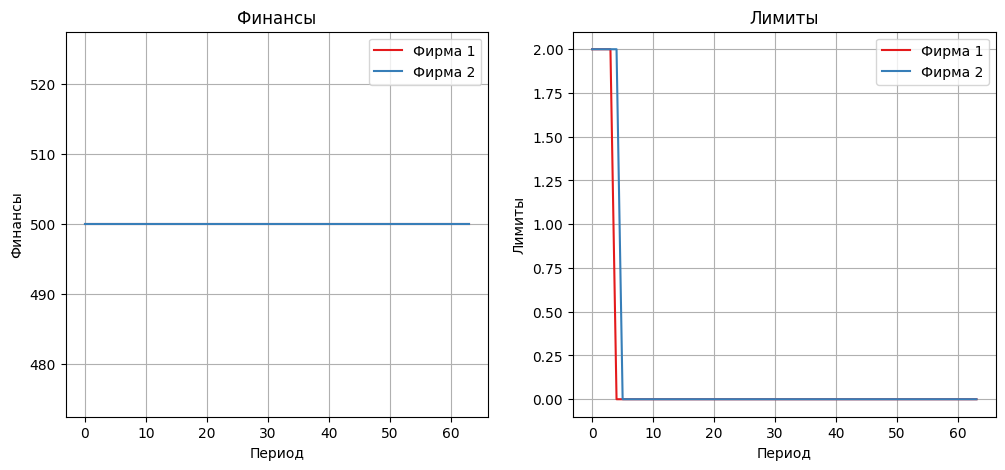

In [37]:
plot_environment(env.state_history)

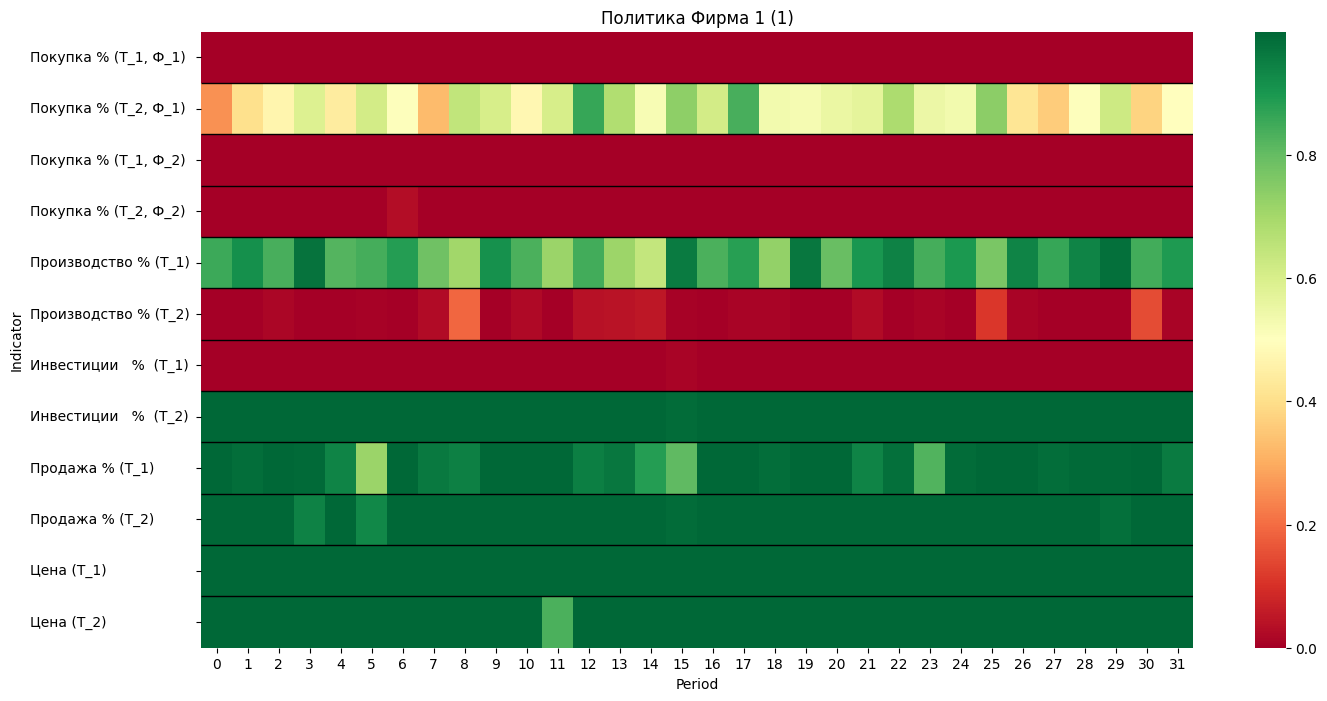

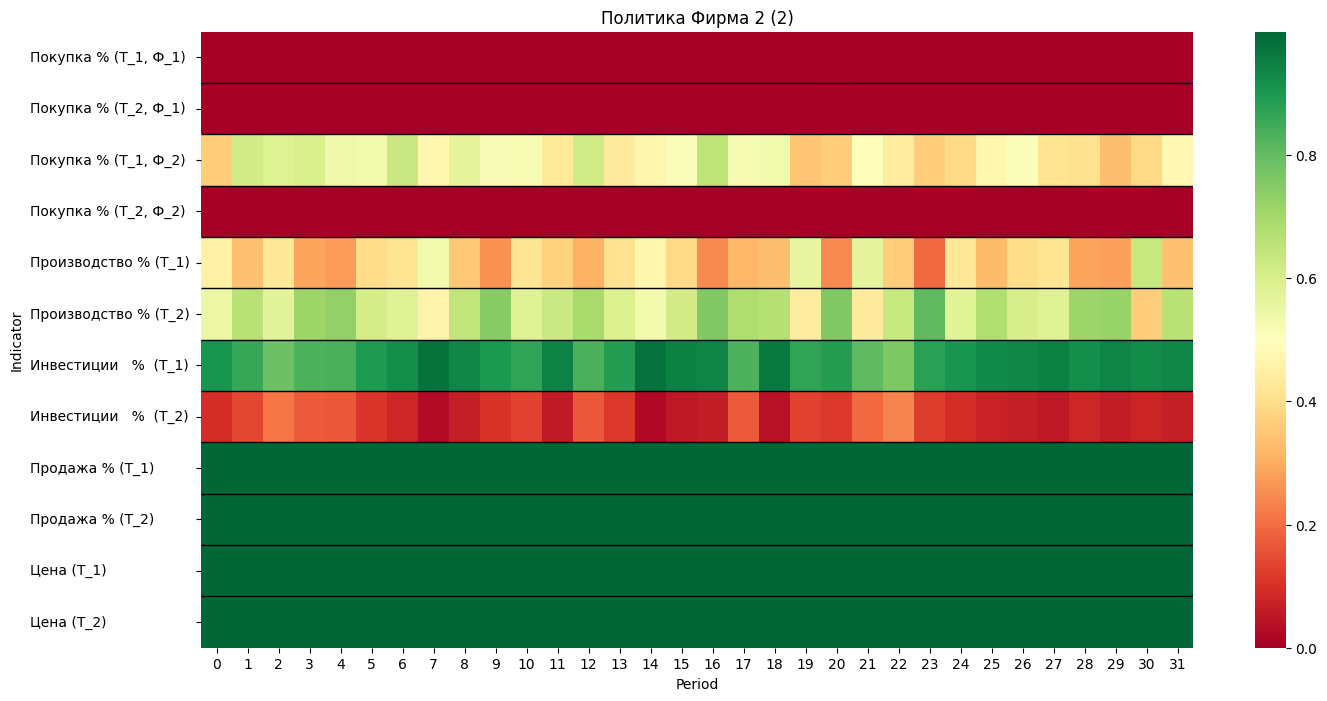

In [38]:
plot_actions(env.actions_history[0], 'Политика Фирма 1 (1)')
plot_actions(env.actions_history[1], 'Политика Фирма 2 (2)')

# Фирмы ориентируются чисто на финансы, больше фирм, разная эффективность

In [18]:
# Производственные функции
prod_functions = [
    BatchedLeontief(torch.tensor([1, 0]), torch.tensor([0, 2]), device=device),  # 1 товара А + 0 товара Б => 2 товара Б 
    BatchedLeontief(torch.tensor([0, 1]), torch.tensor([3, 0]), device=device),  # 0 товара А + 1 товар  Б => 2 товара А.
    BatchedLeontief(torch.tensor([1, 0]), torch.tensor([0, 2]), device=device),  # 1 товара А + 0 товара Б => 2 товара Б 
    BatchedLeontief(torch.tensor([0, 1]), torch.tensor([3, 0]), device=device),  # 0 товара А + 1 товар  Б => 2 товара А.
]
# Инвестиционные функции
invest_functions = [
    BatchedLeontief(torch.tensor([1, 1]), torch.tensor(1), device=device), 
    BatchedLeontief(torch.tensor([1, 1]), torch.tensor(1), device=device), 
    BatchedLeontief(torch.tensor([2, 0]), torch.tensor(1), device=device),  
    BatchedLeontief(torch.tensor([0, 2]), torch.tensor(1), device=device), 
]

In [19]:
env = BatchedEnvironment(market_kwargs,
                         BetaPolicyNetwork2, 
                         prod_functions,
                         invest_functions=invest_functions,
                         target='finance',  # Вот это меняется
                         batch_size=1024)
trainer = TrainerSAC(env,
                     q_critic=CentralizedCritic2,
                     batch_size=512, 
                     buffer_size=524288,
                     learning_rates=(1e-3, 1e-3))

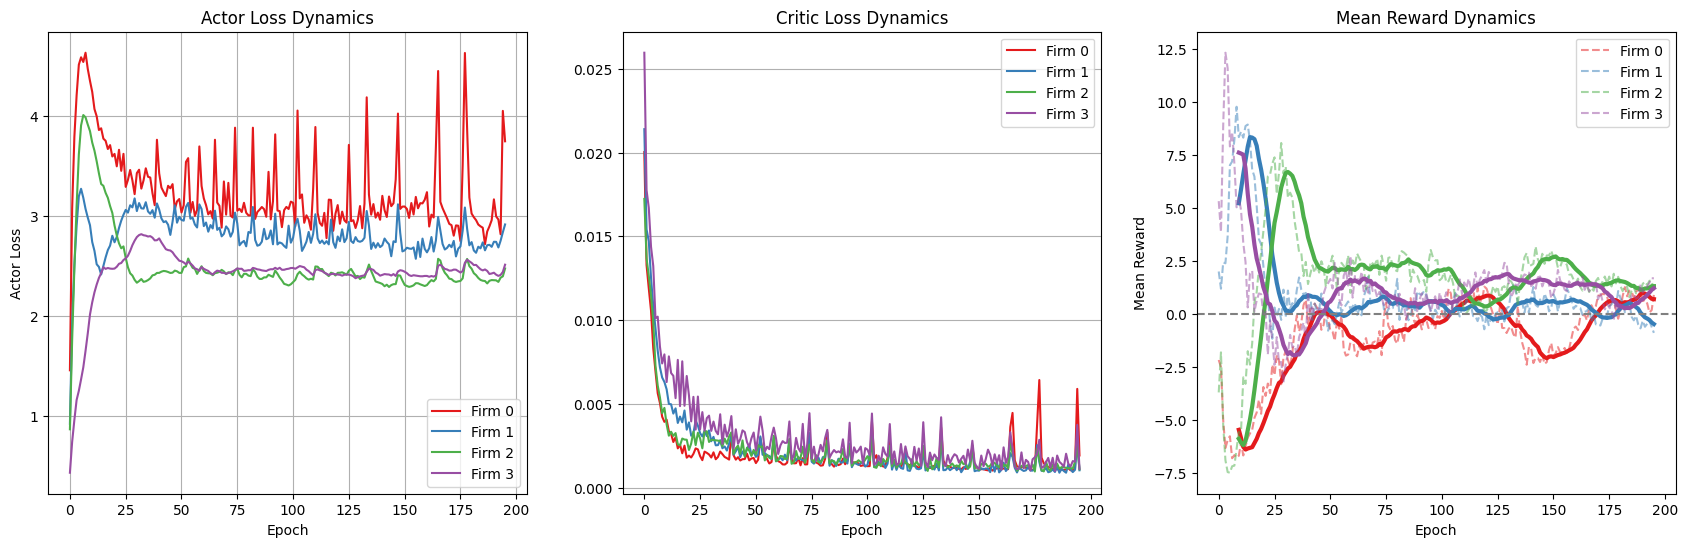

100%|███████████████████████████████| 200/200 [06:27<00:00,  1.94s/it, LR=0.000367, Buffer Index=262144, Order=[0, 2, 3, 1]]


In [20]:
trainer.train(n_epochs=200,
              episode_length=32,
              shuffle_order=True)

In [21]:
env.reset()
env.change_batch_size(1)  

In [22]:
n_periods = 32 * env.market.n_firms
for i in range(n_periods):
    env.step_and_record(i % env.market.n_firms)

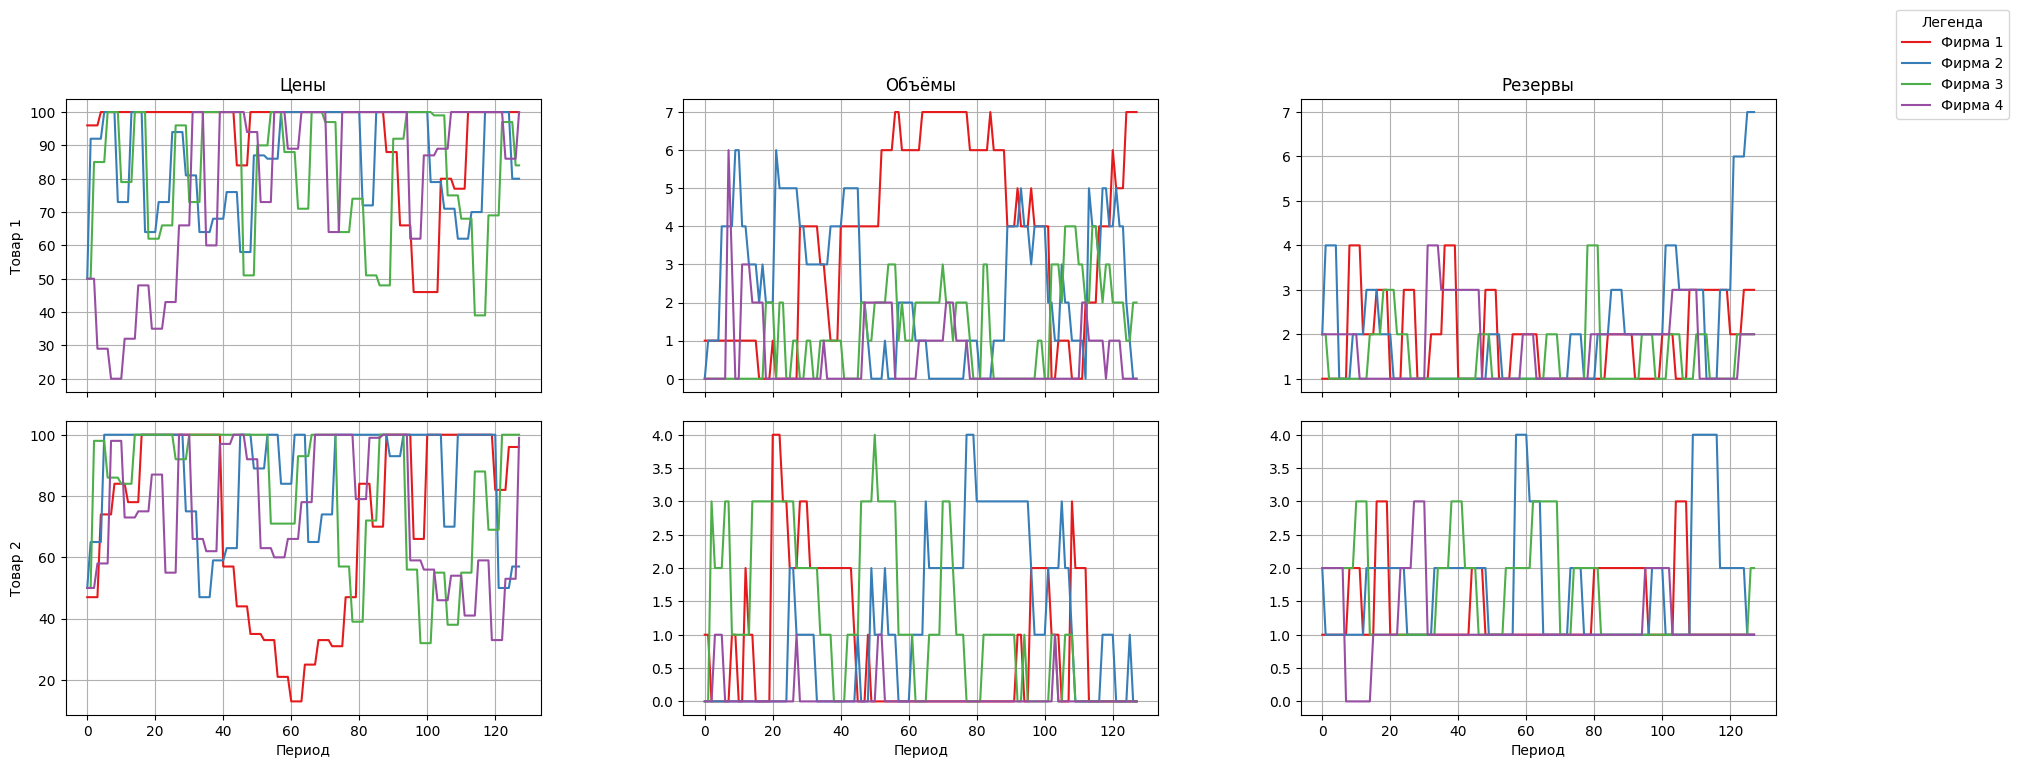

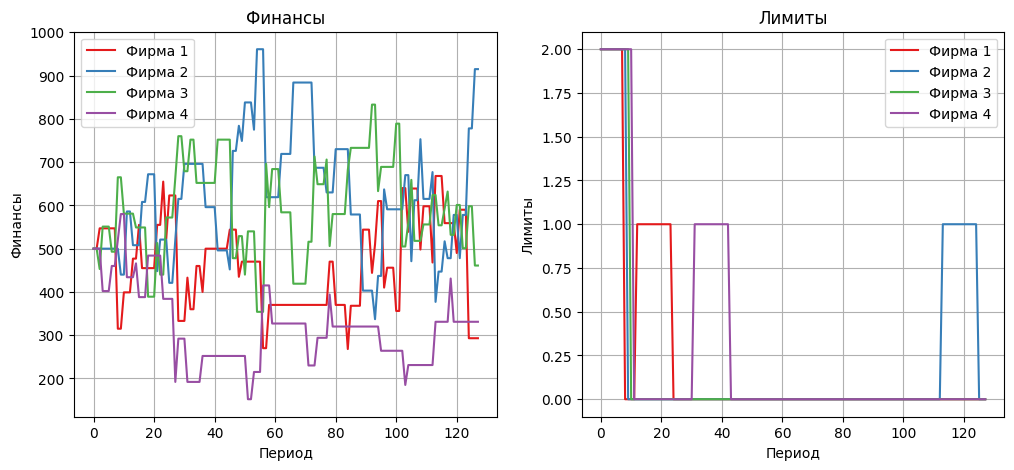

In [23]:
plot_environment(env.state_history)

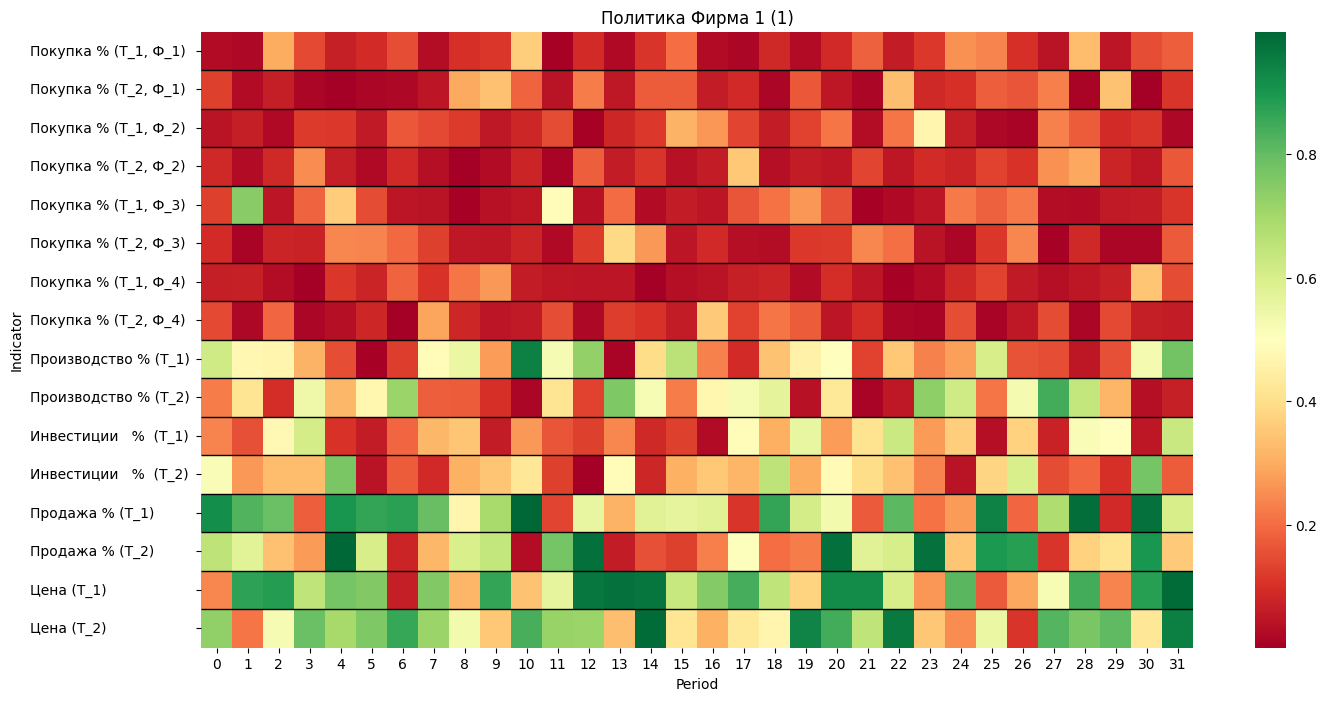

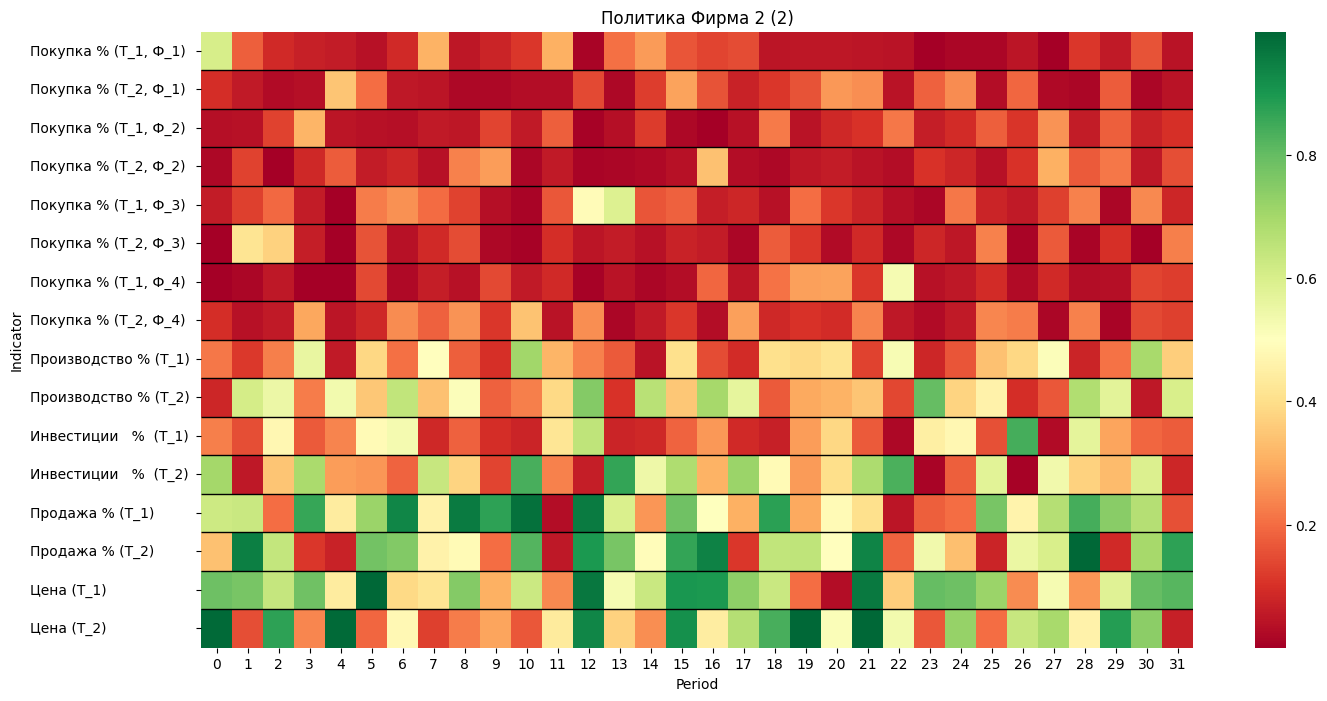

In [34]:
plot_actions(env.actions_history[0], 'Политика Фирма 1 (1)')
plot_actions(env.actions_history[1], 'Политика Фирма 2 (2)')

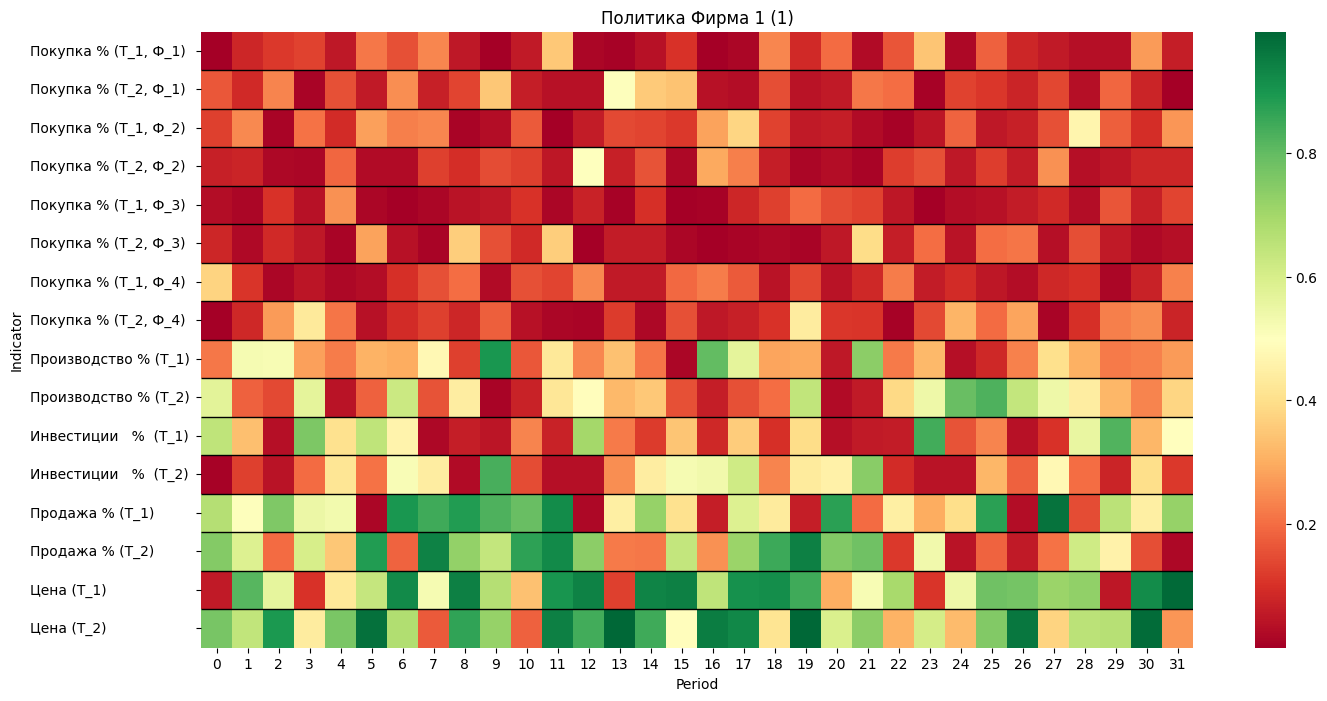

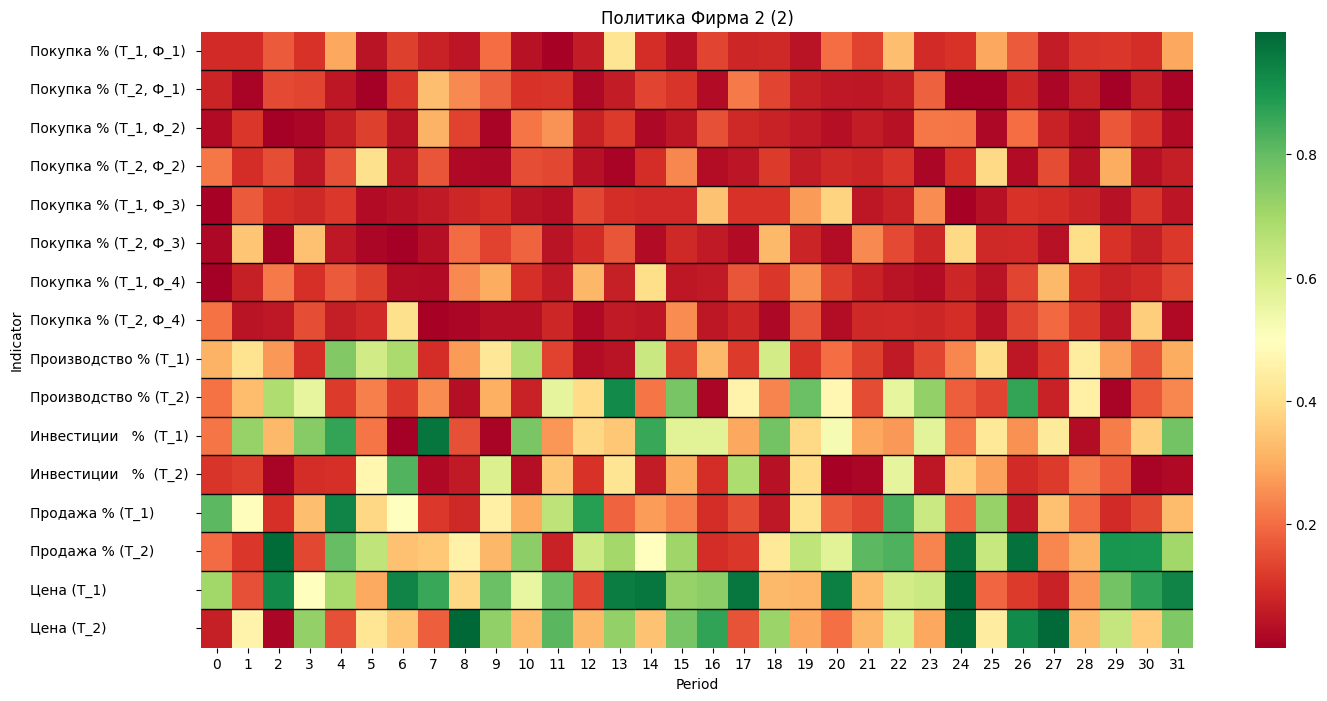

In [35]:
plot_actions(env.actions_history[2], 'Политика Фирма 1 (1)')
plot_actions(env.actions_history[3], 'Политика Фирма 2 (2)')